In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gc
import bisect

In [2]:
from sklearn.metrics import roc_curve 
def score(y,pred): 
    fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1) 
    score=0.4*tpr[np.where(fpr>=0.001)[0][0]]+0.3*tpr[np.where(fpr>=0.005)[0][0]]+0.3*tpr[np.where(fpr>=0.01)[0][0]] 
    return score 
def get_tpr_from_fpr(fpr_array, tpr_array, target):
    fpr_index = np.where(fpr_array == target)
    assert target <= 0.01, 'the value of fpr in the custom metric function need lt 0.01'
    if len(fpr_index[0]) > 0:
        return np.mean(tpr_array[fpr_index])
    else:
        tmp_index = bisect.bisect(fpr_array, target)
        fpr_tmp_1 = fpr_array[tmp_index-1]
        fpr_tmp_2 = fpr_array[tmp_index]
        if (target - fpr_tmp_1) > (fpr_tmp_2 - target):
            tpr_index = tmp_index
        else:
            tpr_index = tmp_index - 1
        return tpr_array[tpr_index]


def eval_metric(pred, labels):
    fpr, tpr, _ = roc_curve(labels, pred, pos_label=1)
    tpr1 = get_tpr_from_fpr(fpr, tpr, 0.001)
    tpr2 = get_tpr_from_fpr(fpr, tpr, 0.005)
    tpr3 = get_tpr_from_fpr(fpr, tpr, 0.01)
    return 'score',0.4*tpr1 + 0.3*tpr2 + 0.3*tpr3,True

In [3]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    return df

In [4]:
def model(features, test_features, n_folds = 5,sample=False):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    features.sort_values(by='date', ascending=True, inplace=True)
        # Extract the ids
    train_ids = features['id']
    test_ids = test_features['id']
    
    # Extract the labels for training
    labels = features['label'].astype(np.uint8)
#     print(labels.isnull())
    
    # Remove the ids and target
    features.drop(columns = ['id', 'label','date'],inplace=True)
    test_features.drop(columns = ['id','date'],inplace=True)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
        # Extract feature names
    feature_names = list(features.columns)
        # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
        # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
        # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
        # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    gc.collect()

        # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    valid_indices = int(len(features)*0.8)
    # Validation data for the fold

    valid_features, valid_labels = features[valid_indices:,:], labels[valid_indices:].astype(np.uint8)
    features = features[:valid_indices,:]
    print(valid_labels.value_counts())
    # Empty array for out of fold validation predictions
    out_of_fold = []
    # Iterate through each fold
    for train_indices, val_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices].astype(np.uint8)
        print(train_labels.value_counts())
    
        if sample:
            train_set = pd.concat([train_features,train_labels],axis=1,columns=feature_names+["label"])
            train_set_0 = train_set.loc[train_set["label"]==0]
            print("the shape of train_set_0 is ", train_set_0.shape)
            train_set_1 = train_set.loc[train_set["label"]==1].reset_index(drop=True)
            print("the shape of train_set_1 is ", train_set_1.shape)
            train_set_0_sample = train_set_0.sample(frac=0.25).reset_index(drop=True)
            train_set_sample = pd.concat([train_set_0_sample,train_set_1],axis=0).reset_index(drop=True)
            train_labels = train_set_sample['label'].astype(np.uint8)
            train_features = train_set_sample.drop(label=['label'],axis=1).values
        # Validation data for the fold
#         valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced',
                                    learning_rate=0.03,
                                    num_leaves=64,
                                    colsample_bytree=.8,
                                    subsample=.9,
                                    max_depth=7,
                                    reg_alpha=.1,
                                    reg_lambda=.1,
                                    min_split_gain=.01,
                                    min_child_weight=2,
                                    silent=-1,
                                    verbose=-1,
                                   n_jobs = -1, 
                                   random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], 
                  early_stopping_rounds = 100, verbose = 200)
            # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
                # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
                # Record the out of fold predictions
        out_of_fold+=np.reshape(model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1],-1).tolist()
                # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
                # Clean up memory
        gc.enable()
        del model, train_features,train_labels
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'id': test_ids, 'score': test_predictions})
        # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
        # Overall validation score
    valid_labels = np.reshape(valid_labels.values,-1).tolist()
    valid_auc = roc_auc_score(list(map(int,valid_labels*n_folds)), out_of_fold)
        # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
        # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    v_name,val_score,flag = eval_metric(out_of_fold,list(map(int,valid_labels*n_folds)))
    valid_scores.append(val_score)
    train_scores.append(np.mean(train_scores))
    fold_names.append('score')
        # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    return submission, feature_importances, metrics
    

In [5]:
df_train = pd.read_csv("../transdata/train_impute_v2.csv",header=0,index_col=None)
# df_train.drop(labels=["date"],axis=1,inplace=True)
df_test = pd.read_csv("../transdata/test_impute_v2.csv", header=0, index_col=None)
# df_test.drop(labels=["date"], axis=1, inplace=True)

the 0th iteration
0    977884
1     16847
Name: label, dtype: int64


/home/bill/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Data Shape:  (994731, 261)
Testing Data Shape:  (500538, 261)
0    195544
1      3403
Name: label, dtype: int64
0    625860
1     10767
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.542903	train's auc: 0.539992
0    625861
1     10766
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.467877	train's auc: 0.516661
0    625840
1     10787
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.555499	train's auc: 0.540509
0    625813
1     10814
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.52894	train's auc: 0.516125
0    625798
1     10830
Name: label, dtype: int64
Training until validation scores don't improve

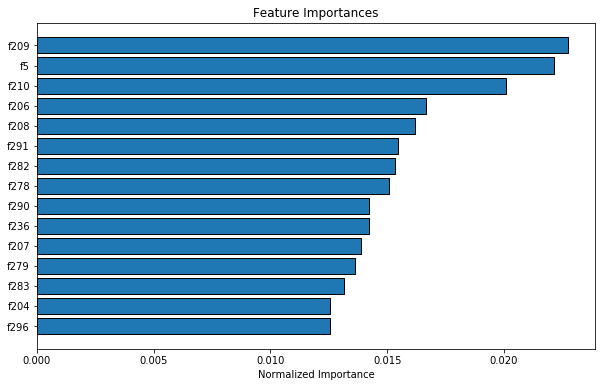

162
the 1th iteration
0    977884
1     16847
Name: label, dtype: int64


/home/bill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bill/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Data Shape:  (994731, 162)
Testing Data Shape:  (500538, 162)
0    195544
1      3403
Name: label, dtype: int64
0    625860
1     10767
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid's auc: 0.520868	train's auc: 0.582425
0    625861
1     10766
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.538716	train's auc: 0.524784
0    625840
1     10787
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.598113	train's auc: 0.519687
0    625813
1     10814
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.48412	train's auc: 0.529541
0    625798
1     10830
Name: label, dtype: int64
Training until validation scores don't improv

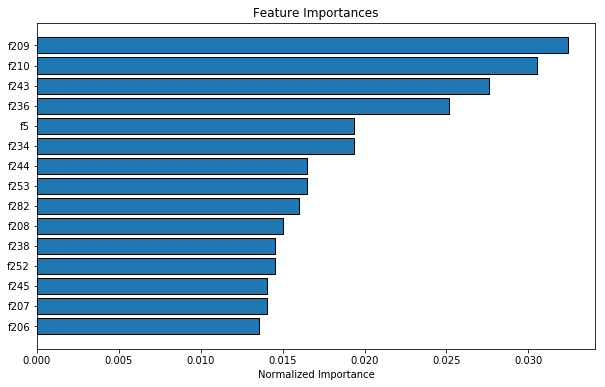

160
the 2th iteration
0    977884
1     16847
Name: label, dtype: int64


/home/bill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bill/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Data Shape:  (994731, 160)
Testing Data Shape:  (500538, 160)
0    195544
1      3403
Name: label, dtype: int64
0    625860
1     10767
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.514999	train's auc: 0.528177
0    625861
1     10766
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.527686	train's auc: 0.526754
0    625840
1     10787
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid's auc: 0.581961	train's auc: 0.556703
0    625813
1     10814
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.503333	train's auc: 0.542015
0    625798
1     10830
Name: label, dtype: int64
Training until validation scores don't improv

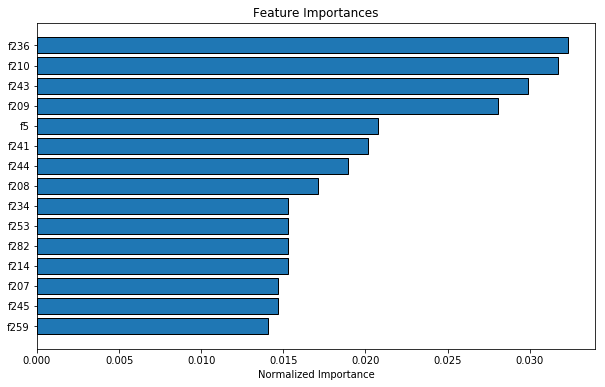

156
the 3th iteration
0    977884
1     16847
Name: label, dtype: int64


/home/bill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bill/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Data Shape:  (994731, 156)
Testing Data Shape:  (500538, 156)
0    195544
1      3403
Name: label, dtype: int64
0    625860
1     10767
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.543337	train's auc: 0.528695
0    625861
1     10766
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.506447	train's auc: 0.517735
0    625840
1     10787
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.64874	train's auc: 0.532775
0    625813
1     10814
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.420637	train's auc: 0.531531
0    625798
1     10830
Name: label, dtype: int64
Training until validation scores don't improve

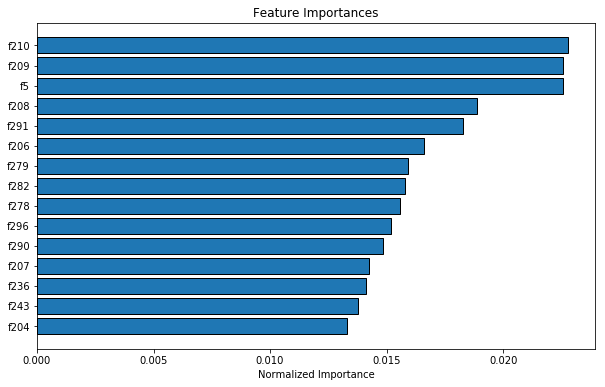

156
the 4th iteration
0    977884
1     16847
Name: label, dtype: int64


/home/bill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bill/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Data Shape:  (994731, 156)
Testing Data Shape:  (500538, 156)
0    195544
1      3403
Name: label, dtype: int64
0    625860
1     10767
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.538511	train's auc: 0.531527
0    625861
1     10766
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.515165	train's auc: 0.521409
0    625840
1     10787
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.557862	train's auc: 0.528865
0    625813
1     10814
Name: label, dtype: int64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.496534	train's auc: 0.521404
0    625798
1     10830
Name: label, dtype: int64
Training until validation scores don't improv

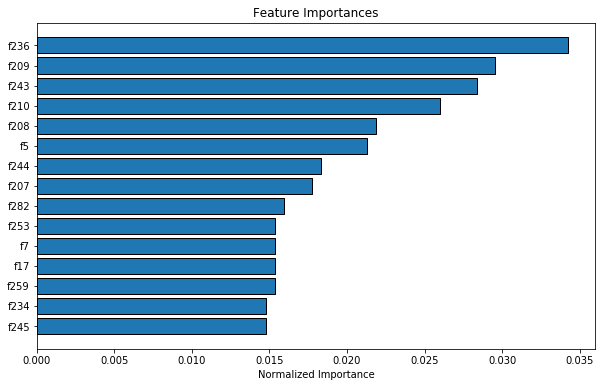

152


In [6]:
n_iter = 5
keep_feature = list(set(df_train.columns)-set(["id","label","date"]))
submission_overall= pd.DataFrame()
for i in range(n_iter):
    print("the {}th iteration".format(i))

    print(df_train["label"].value_counts())
    submission, fi, metrics = model(df_train[keep_feature+["id","label","date"]], df_test[keep_feature+["id","date"]],5,False)
    print('Baseline metrics')
    print(metrics)
    fi_sorted = plot_feature_importances(fi)
    keep_feature = fi_sorted.loc[fi_sorted["importance"]>0.0]["feature"].tolist()
    print(len(keep_feature))
    if i ==0:
        submission_overall=submission
    else:
        submission_overall["score"] = submission_overall["score"].add(submission["score"],fill_value=0)

In [7]:
submission_overall["score"] = submission_overall["score"]/n_iter

In [8]:
import datetime
str_time = str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
submission_file = "../result/2018-07-08/submission_lgb_" +str_time + ".csv"
submission_overall.to_csv(submission_file, index = False)

In [8]:
# del df_train , df_test
# gc.collect()

14